In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import FastText
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def load_data():
    texts = df['kalimat'].tolist()
    labels = df['label'].tolist()
    return texts, labels

texts, labels = load_data()

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenisasi
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Membuat model FastText
fasttext_model = FastText(X_train, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Membuat embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

# Konversi data ke numpy arrays
X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Bagi data training menjadi training dan validasi
X_train, X_val, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.1, random_state=42)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import seaborn as sns

In [ ]:
# Modify your model compilation to include the AUC metric
def create_bidirectional_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(16, return_sequences=False)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

bi_rnn_model = create_bidirectional_model()

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model_RNN.keras', monitor='val_loss', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
]



In [ ]:
# Train the model
hist = bi_rnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7889 - auc_2: 0.8622 - loss: 0.4212
Epoch 1: val_loss improved from inf to 0.07525, saving model to best_model_RNN.keras
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 76s 52ms/step - accuracy: 0.7890 - auc_2: 0.8622 - loss: 0.4210 - val_accuracy: 0.9771 - val_auc_2: 0.9919 - val_loss: 0.0753 - learning_rate: 0.0010
Epoch 2/10
1348/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9506 - auc_2: 0.9854 - loss: 0.1319
Epoch 2: val_loss did not improve from 0.07525
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 63s 47ms/step - accuracy: 0.9505 - auc_2: 0.9854 - loss: 0.1321 - val_accuracy: 0.9760 - val_auc_2: 0.9902 - val_loss: 0.0917 - learning_rate: 0.0010
Epoch 3/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9602 - auc_2: 0.9897 - loss: 0.1094
Epoch 3: val_loss did not improve from 0.07525

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 63s 47ms/step - accuracy: 0.9601 - 

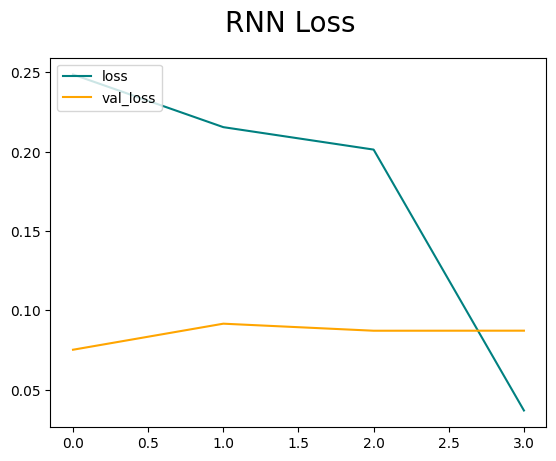

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('RNN Loss', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('rnn_loss.eps', format='eps')
plt.show()

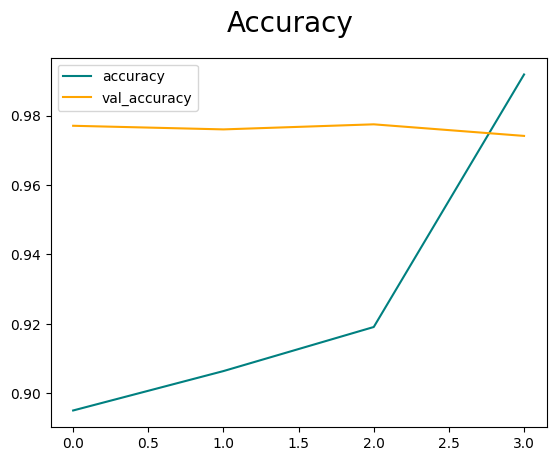

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('rnn_acc.eps', format='eps')
plt.show()

In [ ]:
bi_rnn_pred = (bi_rnn_model.predict(X_test_pad) > 0.5).astype(int)
print("Bidirectional RNN Results:")
print(classification_report(y_test, bi_rnn_pred))

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step
Bidirectional RNN Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     55827
           1       0.81      0.98      0.89      5936

    accuracy                           0.98     61763
   macro avg       0.90      0.98      0.94     61763
weighted avg       0.98      0.98      0.98     61763



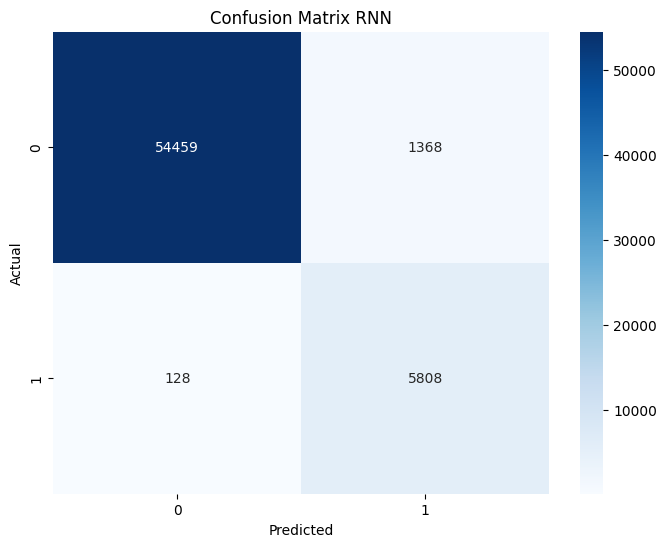

In [ ]:
cm = confusion_matrix(y_test, bi_rnn_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix RNN')
plt.show()

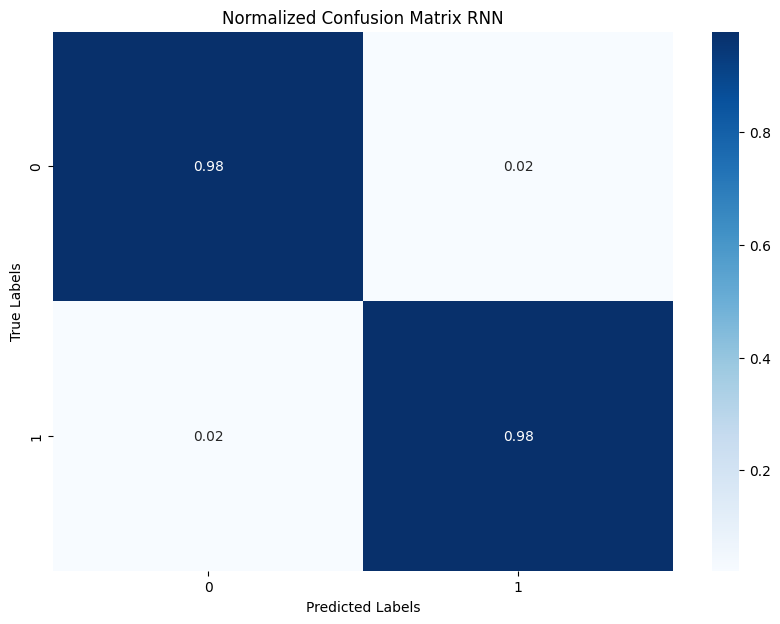

In [ ]:
# Compute confusion matrix with normalization
cm_normalized = confusion_matrix(y_test, bi_rnn_pred, normalize='true')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix RNN')

plt.savefig('confusion_matrix_normalized_rnn.eps', format='eps')

# Show the plot
plt.show()

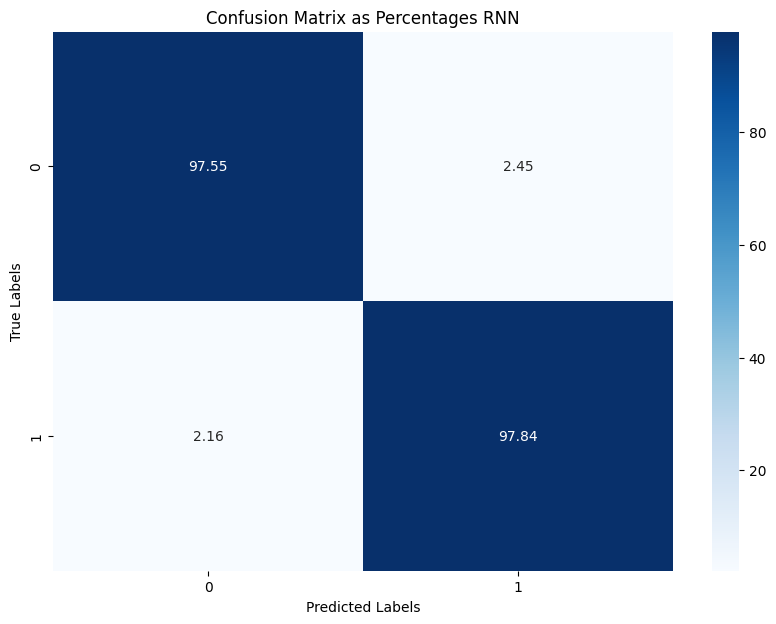

In [ ]:
# Convert to percentage
cm_percentage = cm_normalized * 100

# Plot confusion matrix as percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix as Percentages RNN')

plt.savefig('confusion_matrix_Percentages_rnn.eps', format='eps')

plt.show()

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step


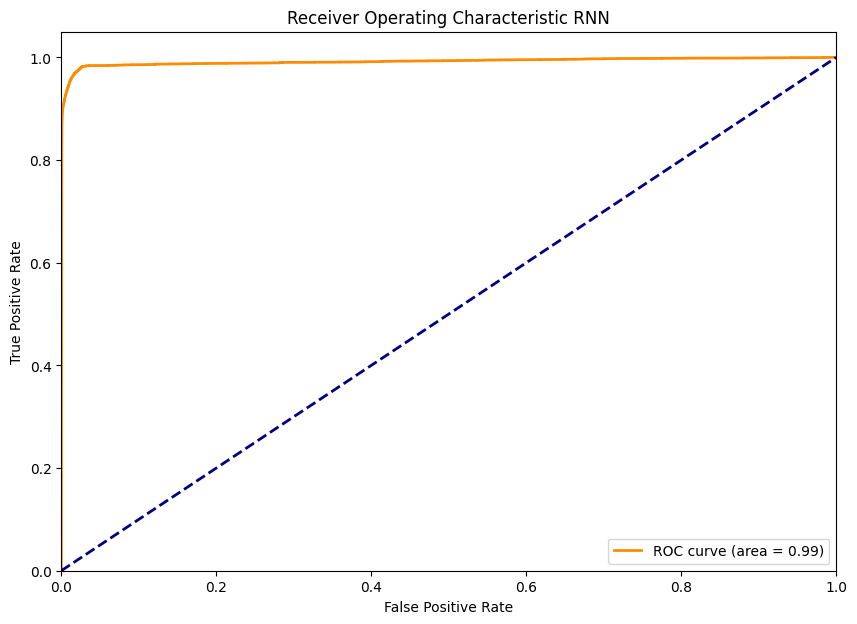

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_prob = bi_rnn_model.predict(X_test_pad).ravel()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic RNN')
plt.legend(loc="lower right")
plt.savefig('roc_curve_rnn.eps', format='eps')
plt.show()

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step


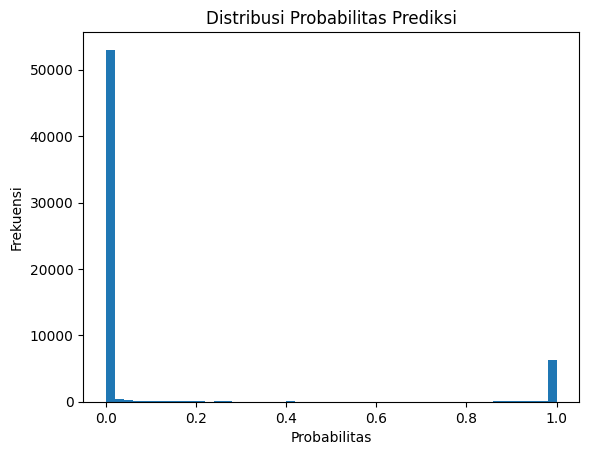

In [ ]:
import matplotlib.pyplot as plt

# Asumsikan output terakhir dari model adalah pred_probs
pred_probs = bi_rnn_model.predict(X_test_pad)
plt.hist(pred_probs, bins=50)
plt.title('Distribusi Probabilitas Prediksi')
plt.xlabel('Probabilitas')
plt.ylabel('Frekuensi')
plt.show()

# LSTM

In [ ]:
def create_bidirectional_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model


bi_lstm_model = create_bidirectional_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import tensorflow as tf

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model_lstm.keras', monitor='val_loss', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
]

# Train the model with the callbacks
hist = bi_lstm_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
1348/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8794 - auc_3: 0.9403 - loss: 0.2601
Epoch 1: val_loss improved from inf to 0.03807, saving model to best_model_lstm.keras
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - accuracy: 0.8795 - auc_3: 0.9404 - loss: 0.2599 - val_accuracy: 0.9839 - val_auc_3: 0.9984 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 2/10
1348/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9877 - auc_3: 0.9988 - loss: 0.0316
Epoch 2: val_loss did not improve from 0.03807
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - accuracy: 0.9877 - auc_3: 0.9988 - loss: 0.0316 - val_accuracy: 0.9825 - val_auc_3: 0.9989 - val_loss: 0.0385 - learning_rate: 0.0010
Epoch 3/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9965 - auc_3: 0.9998 - loss: 0.0108
Epoch 3: val_loss did not improve from 0.03807

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.9965 -

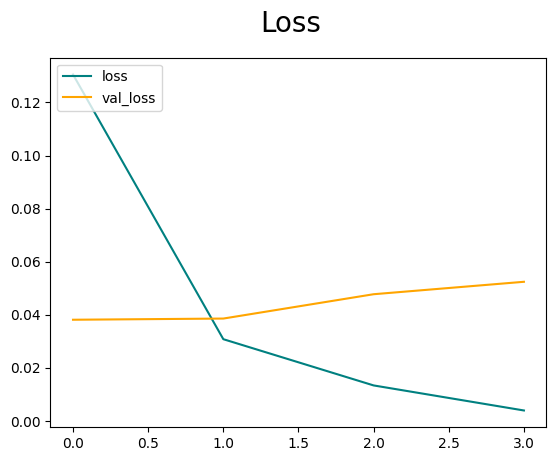

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('lstm_loss.eps', format='eps')
plt.show()

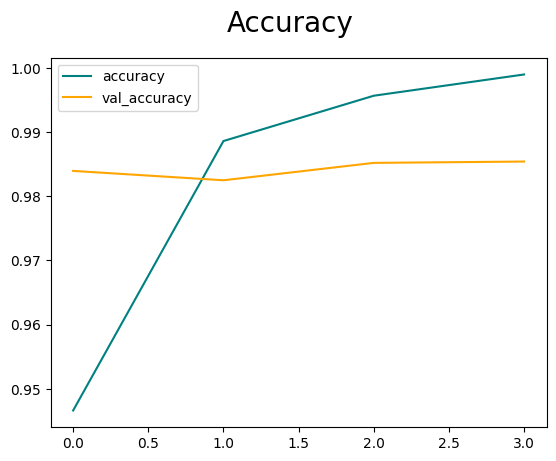

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('lstm_acc.eps', format='eps')
plt.show()

In [ ]:
bi_lstm_pred = (bi_lstm_model.predict(X_test_pad) > 0.5).astype(int)
print("Bidirectional LSTM Results:")
print(classification_report(y_test, bi_lstm_pred))

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
Bidirectional LSTM Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     55827
           1       0.80      0.99      0.88      5936

    accuracy                           0.97     61763
   macro avg       0.90      0.98      0.93     61763
weighted avg       0.98      0.97      0.98     61763



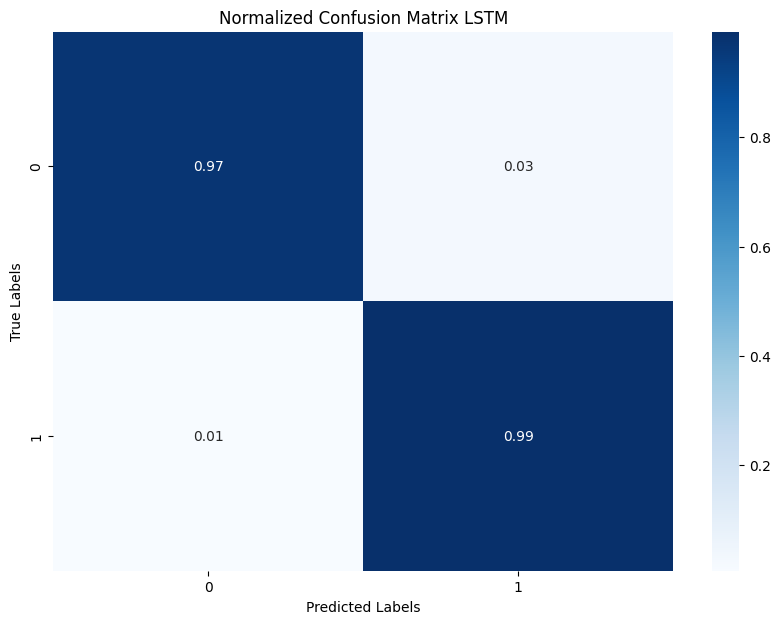

In [ ]:
# Compute confusion matrix with normalization
cm_normalized = confusion_matrix(y_test, bi_lstm_pred, normalize='true')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix LSTM')

plt.savefig('confusion_matrix_normalized_lstm.eps', format='eps')

# Show the plot
plt.show()

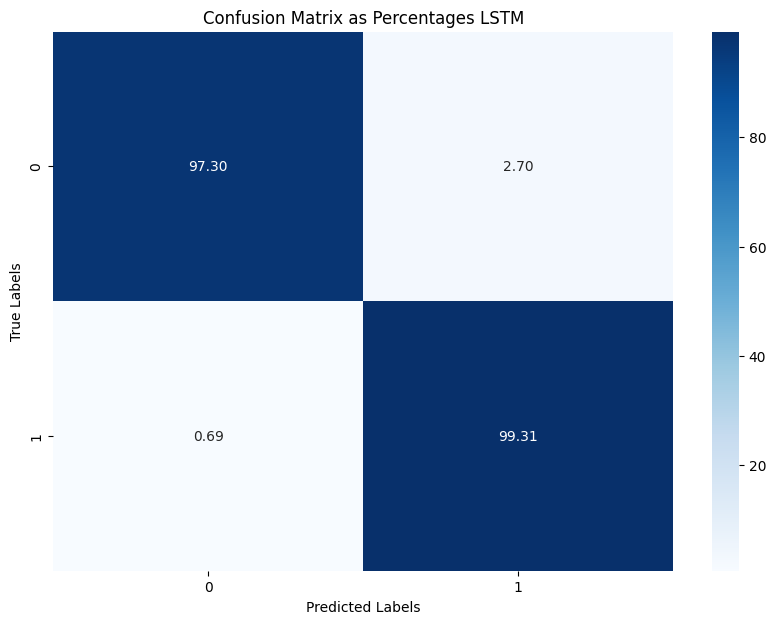

In [ ]:
# Convert to percentage
cm_percentage = cm_normalized * 100

# Plot confusion matrix as percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix as Percentages LSTM')

plt.savefig('confusion_matrix_Percentages_lstm.eps', format='eps')

plt.show()

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step


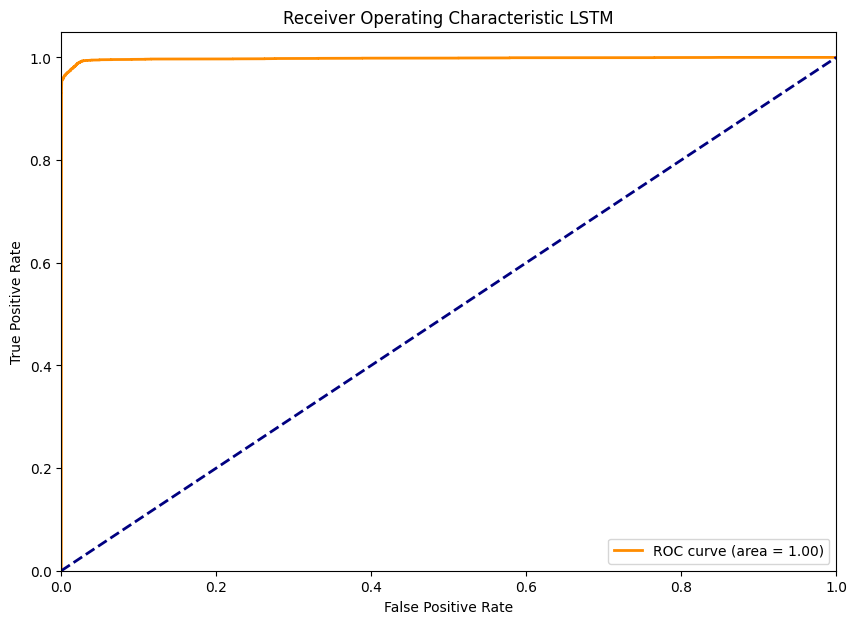

In [ ]:
# Predict probabilities for the test set
y_pred_prob = bi_lstm_model.predict(X_test_pad).ravel()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic LSTM')
plt.legend(loc="lower right")
plt.savefig('roc_curve_lstm.eps', format='eps')
plt.show()

# GRU

In [ ]:
def create_bidirectional_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16, return_sequences=False)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

bi_gru_model = create_bidirectional_model()

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model_gru.keras', monitor='val_loss', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
]

# Train the model with the callbacks
hist = bi_gru_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
1348/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8788 - auc_5: 0.9404 - loss: 0.2419
Epoch 1: val_loss improved from inf to 0.03512, saving model to best_model_gru.keras
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 60s 41ms/step - accuracy: 0.8789 - auc_5: 0.9404 - loss: 0.2417 - val_accuracy: 0.9846 - val_auc_5: 0.9988 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 2/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9926 - auc_5: 0.9993 - loss: 0.0224
Epoch 2: val_loss did not improve from 0.03512
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - accuracy: 0.9926 - auc_5: 0.9993 - loss: 0.0224 - val_accuracy: 0.9850 - val_auc_5: 0.9984 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 3/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9983 - auc_5: 1.0000 - loss: 0.0059
Epoch 3: val_loss did not improve from 0.03512

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.9983 - 

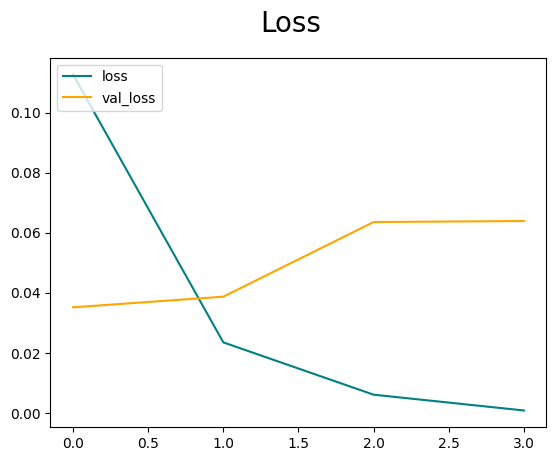

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('gru_loss.eps', format='eps')
plt.show()

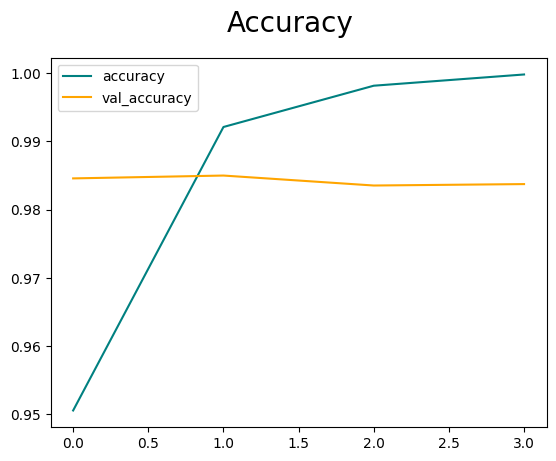

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('gru_acc.eps', format='eps')
plt.show()

In [ ]:
bi_gru_pred = (bi_gru_model.predict(X_test_pad) > 0.5).astype(int)
print("Bidirectional GRU Results:")
print(classification_report(y_test, bi_gru_pred))

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
Bidirectional GRU Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     55827
           1       0.93      0.97      0.95      5936

    accuracy                           0.99     61763
   macro avg       0.97      0.98      0.97     61763
weighted avg       0.99      0.99      0.99     61763



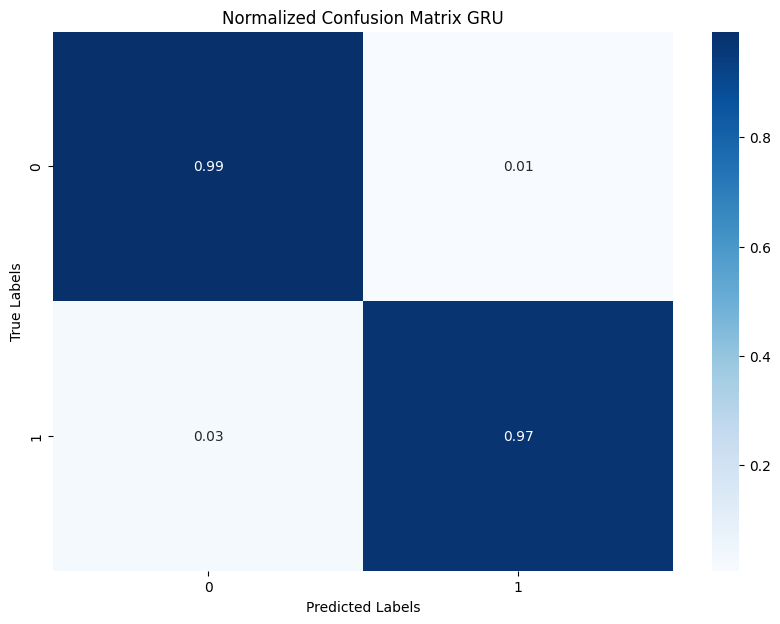

In [ ]:
# Compute confusion matrix with normalization
cm_normalized = confusion_matrix(y_test, bi_gru_pred, normalize='true')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix GRU')

plt.savefig('confusion_matrix_normalized_gru.eps', format='eps')

# Show the plot
plt.show()

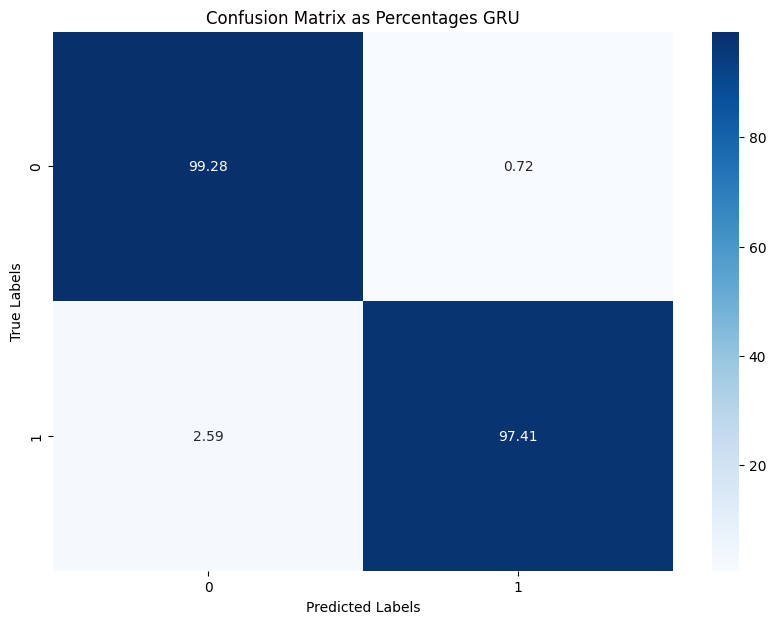

In [ ]:
# Convert to percentage
cm_percentage = cm_normalized * 100

# Plot confusion matrix as percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix as Percentages GRU')

plt.savefig('confusion_matrix_Percentages_gru.eps', format='eps')

plt.show()

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step


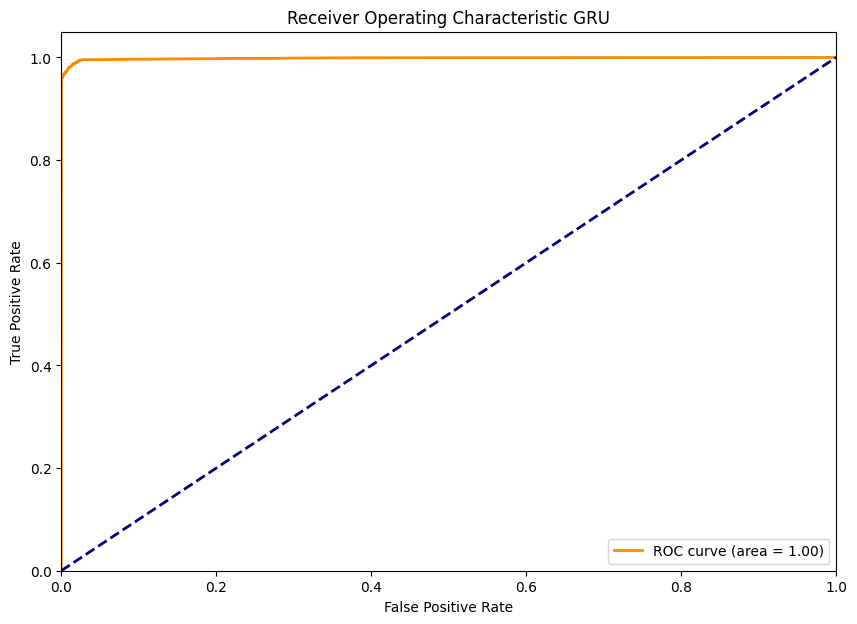

In [ ]:
# Predict probabilities for the test set
y_pred_prob = bi_gru_model.predict(X_test_pad).ravel()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic GRU')
plt.legend(loc="lower right")
plt.savefig('roc_curve_gru.eps', format='eps')
plt.show()

# CNN

In [ ]:
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

cnn_model = create_cnn_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model_cnn.keras', monitor='val_loss', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
]

# Train the model with the callbacks
hist = cnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9176 - auc_6: 0.9657 - loss: 0.1777
Epoch 1: val_loss improved from inf to 0.02665, saving model to best_model_cnn.keras
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9176 - auc_6: 0.9657 - loss: 0.1776 - val_accuracy: 0.9873 - val_auc_6: 0.9993 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 2/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9940 - auc_6: 0.9996 - loss: 0.0167
Epoch 2: val_loss did not improve from 0.02665
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9940 - auc_6: 0.9996 - loss: 0.0167 - val_accuracy: 0.9856 - val_auc_6: 0.9992 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 3/10
1346/1349 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - auc_6: 0.9999 - loss: 0.0043
Epoch 3: val_loss did not improve from 0.02665

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9985 - auc_6

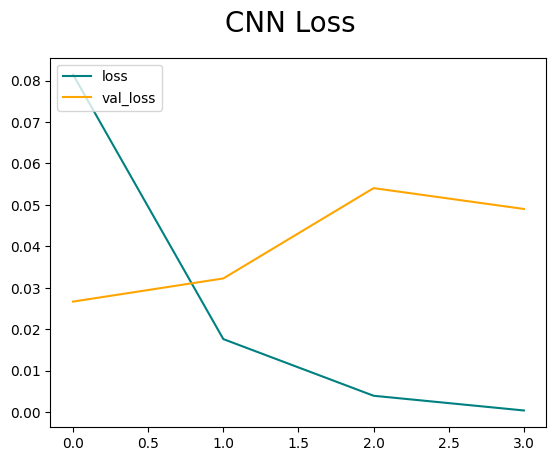

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('CNN Loss', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('cnn_loss.eps', format='eps')
plt.show()

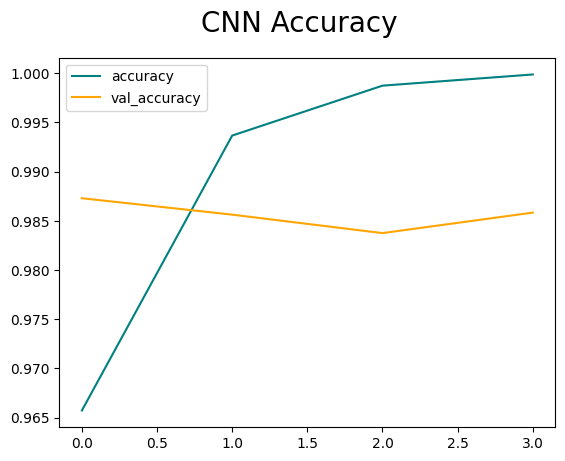

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('CNN Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.savefig('cnn_acc.eps', format='eps')
plt.show()

In [ ]:
cnn_pred = (cnn_model.predict(X_test_pad) > 0.5).astype(int)
print("CNN Results:")
print(classification_report(y_test, cnn_pred))

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
CNN Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     55827
           1       0.87      0.99      0.93      5936

    accuracy                           0.98     61763
   macro avg       0.94      0.99      0.96     61763
weighted avg       0.99      0.98      0.99     61763



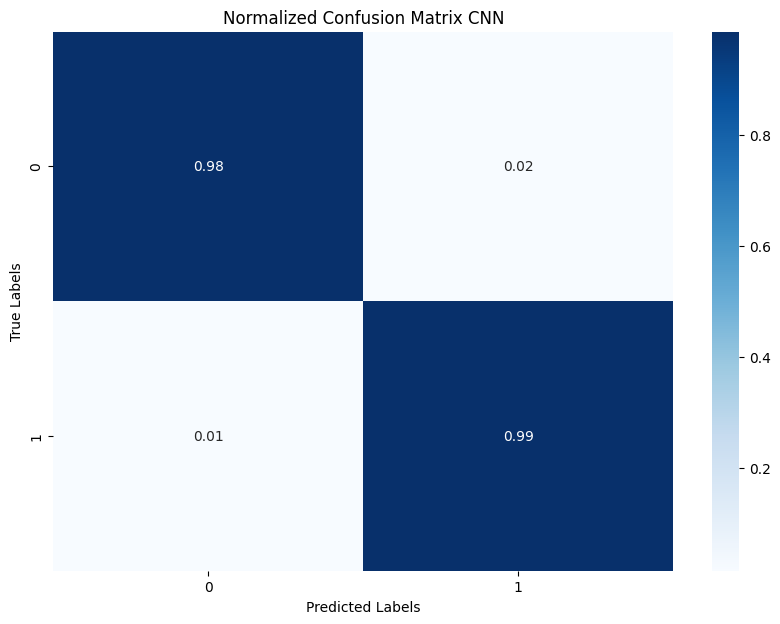

In [ ]:
# Compute confusion matrix with normalization
cm_normalized = confusion_matrix(y_test, cnn_pred, normalize='true')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix CNN')

plt.savefig('confusion_matrix_normalized_cnn.eps', format='eps')

# Show the plot
plt.show()

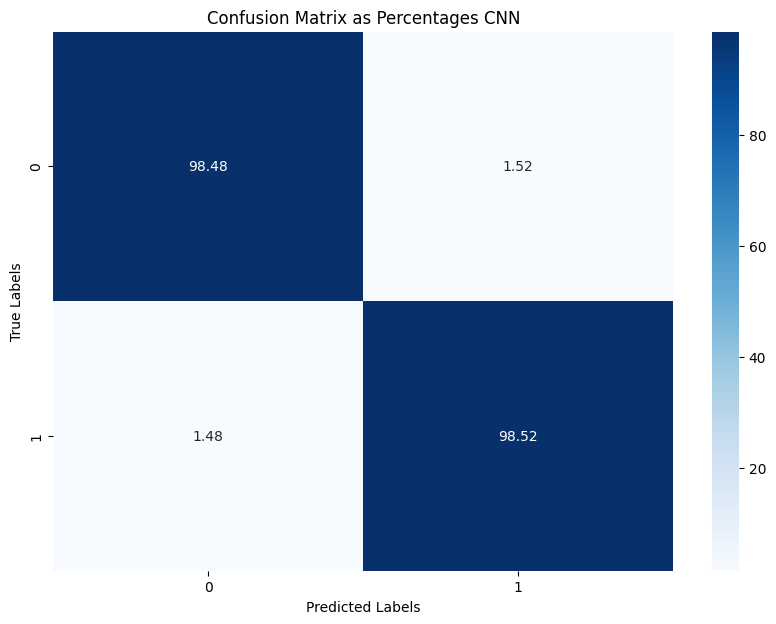

In [ ]:
# Convert to percentage
cm_percentage = cm_normalized * 100

# Plot confusion matrix as percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix as Percentages CNN')

plt.savefig('confusion_matrix_Percentages_cnn.eps', format='eps')

plt.show()

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


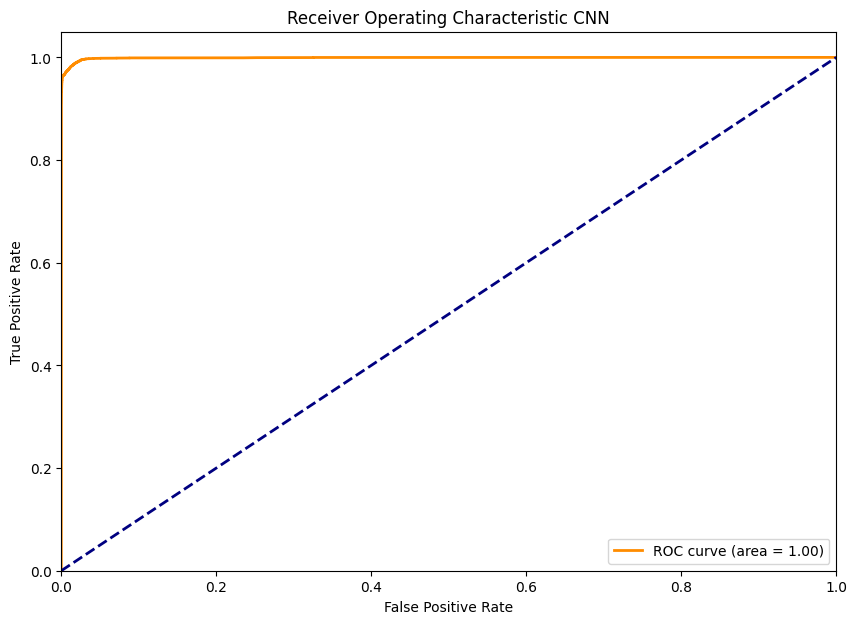

In [ ]:
# Predict probabilities for the test set
y_pred_prob = cnn_model.predict(X_test_pad).ravel()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic CNN')
plt.legend(loc="lower right")
plt.savefig('roc_curve_cnn.eps', format='eps')
plt.show()

# SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize the SVM model with probability=True
svm_model = SVC(kernel='rbf', probability=True)

# Train the model
svm_model.fit(X_train, y_train)

In [ ]:
y_pred = svm_model.predict(X_test_pad)

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     55827
           1       0.19      0.43      0.26      5936

    accuracy                           0.77     61763
   macro avg       0.56      0.62      0.56     61763
weighted avg       0.86      0.77      0.81     61763



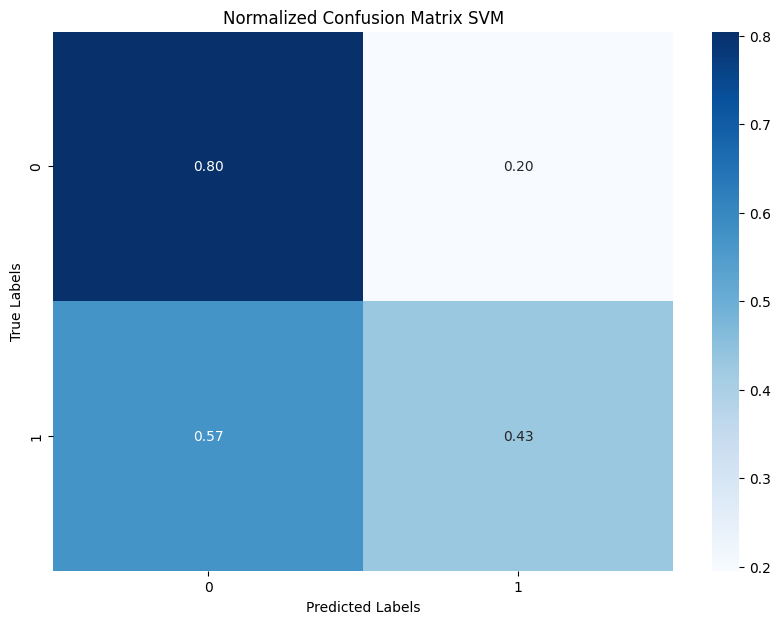

In [ ]:
# Compute confusion matrix with normalization
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix SVM')

plt.savefig('confusion_matrix_normalized_svm.eps', format='eps')

# Show the plot
plt.show()

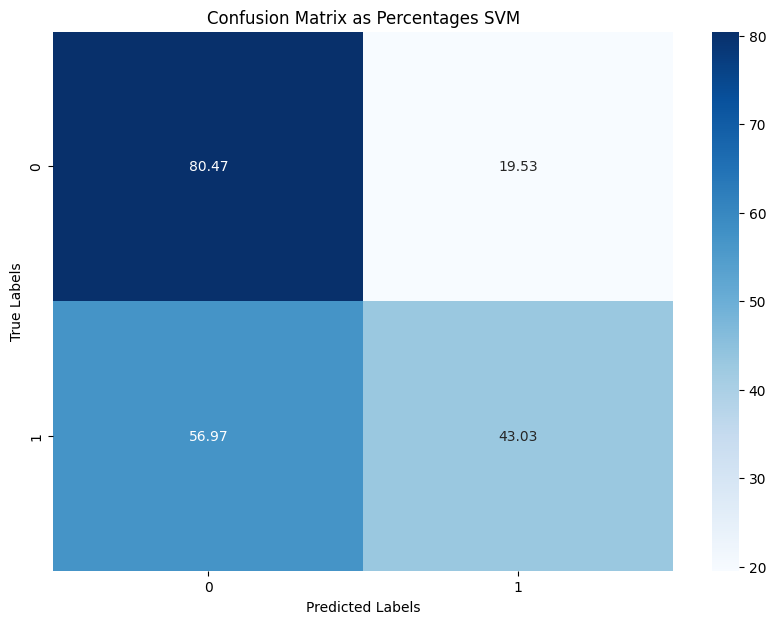

In [ ]:
# Convert to percentage
cm_percentage = cm_normalized * 100

# Plot confusion matrix as percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix as Percentages SVM')

plt.savefig('confusion_matrix_Percentages_svm.eps', format='eps')

plt.show()

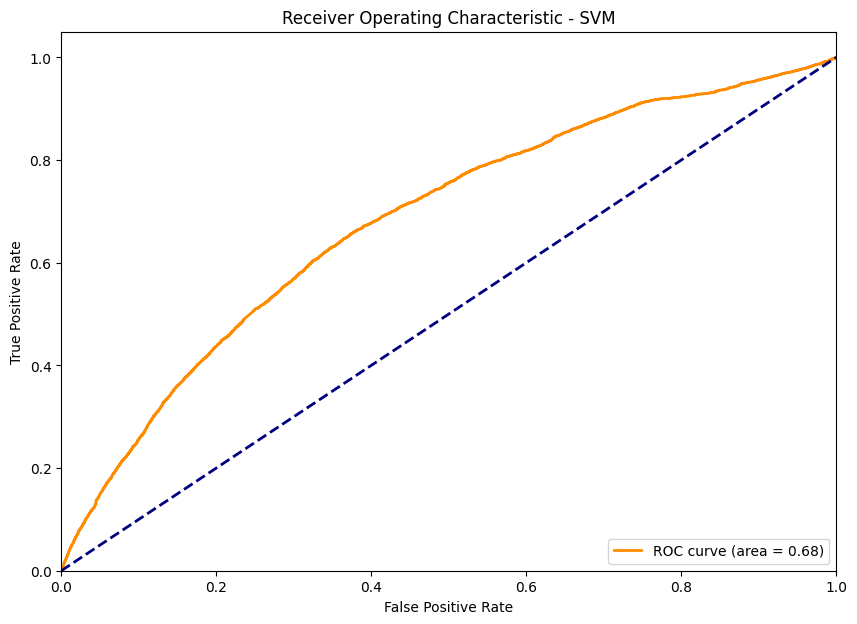

In [ ]:
# Compute ROC curve and ROC AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc="lower right")
plt.savefig('roc_svm.eps', format='eps')
plt.show()

In [ ]:
import pickle

# Save the tokenizer to a file
with open('svm_model.pkl', 'wb') as handle:
    pickle.dump(svm_model, handle, protocol=pickle.HIGHEST_PROTOCOL)